<a href="https://colab.research.google.com/github/kacper-dobrow/tensorflow-course/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow part 2: fine-tuning

In the previous notebook we covered feature extraction. Now let's learn fine-tuning.

In [1]:
!nvidia-smi

Tue Oct 17 07:39:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebook we've created some helper functions. However, this is tedious, so let's import them all at once

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-17 07:41:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-17 07:41:57 (110 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import walk_through_dir, unzip_data, plot_loss_curves, create_tensorboard_callback

## Getting data

Using pretrained models contained within TensorFlow, specifically `tf.keras.applications`

In [5]:
# get 10% of training data of 10 classes of food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
#unzip the data
unzip_data("10_food_classes_10_percent.zip")
#walk through directory - check out how many subdirectories and images there are
walk_through_dir("10_food_classes_10_percent/")

--2023-10-17 07:54:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.74.207, 173.194.192.207, 209.85.145.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.74.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   171MB/s    in 0.9s    

2023-10-17 07:54:35 (171 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]

There are 2 directories and 0 images in '10_food_classes_10_percent/'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_foo

In [6]:
# Create the training and test directory paths
train_dir = "/content/10_food_classes_10_percent/train/"
test_dir = "/content/10_food_classes_10_percent/test/"

Previously we used ImageDataGenerator class. This is the vanilla TensorFlow way.

However, there's a new faster way `tf.keras.utils.image_dataset_from_directory`

In [7]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                                    image_size=IMG_SIZE,
                                                                    label_mode="categorical",
                                                                    batch_size=BATCH_SIZE) #default so not needed
test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        image_size=IMG_SIZE,
                                                        label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
# Check out the class names
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

Keras Sequential API - define layers one by one

Keras Functional API - define the following layer as a function into which the previous layer output goes as input

## Model 0: Building a transfer learning model using the Keras Functional API

Functional API is more flexible

In [14]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model layers
base_model.trainable = False

# 3. Create inputs to our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. (optional for EfficientNetB0. If using other models, this strep is necessary) normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model in order to aggregate most important information and reduce number of computations
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling 2D: {x.shape}")

# 7. Create output activation layer
outputs = tf.keras.layers.Dense(len(train_data_10_percent.class_names),
                                activation="softmax",
                                name="output_layer")(x)

# 8. Compine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)), # validating for a quarter of data in order to fit quicker
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="model_0")])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling 2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/model_0/20231017-092941
Epoch 1/5
24/24 [==============================] - 12s 224ms/step - loss: 1.9157 - accuracy: 0.3667 - val_loss: 1.3059 - val_accuracy: 0.7105
Epoch 2/5
24/24 [==============================] - 4s 138ms/step - loss: 1.1304 - accuracy: 0.7480 - val_loss: 0.8523 - val_accuracy: 0.8289
Epoch 3/5
24/24 [==============================] - 4s 173ms/step - loss: 0.8151 - accuracy: 0.8160 - val_loss: 0.6724 - val_accuracy: 0.8487
Epoch 4/5
24/24 [==============================] - 5s 180ms/step - loss: 0.6521 - accuracy: 0.8467 - val_loss: 0.5917 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 5s 181ms/step - loss: 0.5626 - accuracy: 0.8693 - val_loss: 0.5263 - val_accuracy: 0.8684


In [15]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 83ms/step - loss: 0.5589 - accuracy: 0.8636


[0.5589112043380737, 0.8636000156402588]

In [16]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_6
1 rescaling_10
2 normalization_5
3 rescaling_11
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activa

In [18]:
# Get the summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_10 (Rescaling)    (None, None, None, 3)        0         ['input_6[0][0]']             
                                                                                                  
 normalization_5 (Normaliza  (None, None, None, 3)        7         ['rescaling_10[0][0]']        
 tion)                                                                                            
                                                                                                  
 rescaling_11 (Rescaling)    (None, None, None, 3)        0         ['normalization_5

In [19]:
# Summary of the whole model
model_0.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
________________

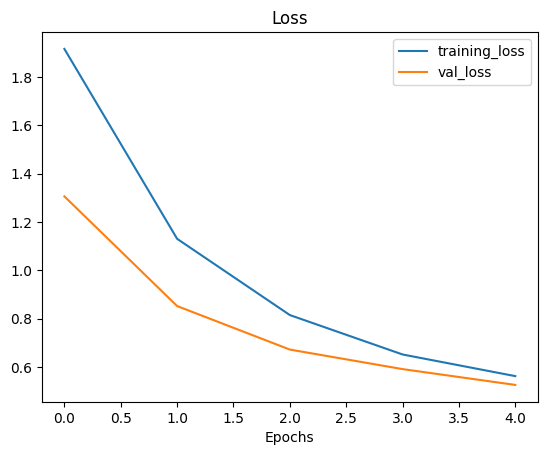

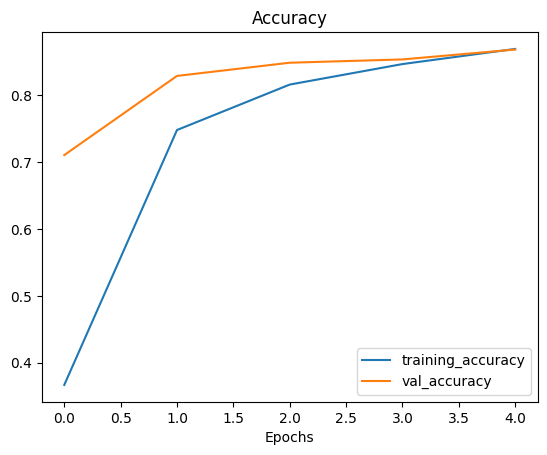

In [20]:
# Check out the model's training curves
plot_loss_curves(history_0)

## Running a series of experiments

1. Feature extraction model with 1% of the training data with data augmentation
2. Feature extraction with 10% of the data and augmantation
3. Fine-tuning on 10% of the training data with data augmentation
4. Fine tuning with 100% of the training data

### Experiment 1: Feature extraction, 1% of the data, augmented

#### Loading and preprocessing data

In [21]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-10-17 10:26:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.207, 142.250.125.207, 142.250.136.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   106MB/s    in 1.2s    

2023-10-17 10:26:44 (106 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [23]:
# Create train and test dirs
train_dir_1 = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [24]:
# How many images are there
walk_through_dir("10_food_classes_1_percent/")

There are 2 directories and 0 images in '10_food_classes_1_percent/'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There 

In [25]:
# Set up data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.utils.image_dataset_from_directory(train_dir_1,
                                                                   label_mode="categorical",
                                                                   image_size=IMG_SIZE,
                                                                   batch_size=BATCH_SIZE)
test_data = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                        label_mode="categorical",
                                                        image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#### Augmenting the data
Data augmentation is implemented at the level of a layer in our model
* `tf.keras.layers.experimental.preprocessing.()`

The preprocessing layer is only on during training!?!?!?!?

In [28]:
from tensorflow.keras.layers.experimental import preprocessing
# Create augmentation stage with flips, zooms, rotations etc
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
#    preprocessing.Rescale(1./255.)
], name="data_augmentation")

In [29]:
tf.__version__

'2.13.0'